In [1]:
import zipfile
import os

# Define paths
zip_path_1 = '/content/drive/MyDrive/HAM10000 dir/HAM10000_images_part_1.zip'
zip_path_2 = '/content/drive/MyDrive/HAM10000 dir/HAM10000_images_part_2.zip'
extract_path = '/content/'
output_folder_1 = os.path.join(extract_path, 'HAM10000 PT1')
output_folder_2 = os.path.join(extract_path, 'HAM10000 PT2')

# Create output folders if they don't exist
os.makedirs(output_folder_1, exist_ok=True)
os.makedirs(output_folder_2, exist_ok=True)

# Function to unzip a file to a specific directory
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip the first file into the first output folder
unzip_file(zip_path_1, output_folder_1)

# Unzip the second file into the second output folder
unzip_file(zip_path_2, output_folder_2)

print(f"Files from {zip_path_1} have been extracted to {output_folder_1}")
print(f"Files from {zip_path_2} have been extracted to {output_folder_2}")

Files from /content/drive/MyDrive/HAM10000 dir/HAM10000_images_part_1.zip have been extracted to /content/HAM10000 PT1
Files from /content/drive/MyDrive/HAM10000 dir/HAM10000_images_part_2.zip have been extracted to /content/HAM10000 PT2


In [2]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import numpy as np
import cv2
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception,VGG16,ResNet50
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.random import seed

In [3]:
# Define the path to your CSV file
csv_file_path = '/content/HAM10000_metadata'

# Read the CSV file with the correct delimiter
df = pd.read_csv(csv_file_path, delimiter=',')
#read metadata
df_skin = df
# Display the dataframe
df_skin.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [4]:
df_skin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [5]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']

lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

df_skin['lesion_type']=df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)

print('Total number of images',len(df_skin))
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')

df_skin['lesion_type'].value_counts()

Total number of images 10015
The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


lesion_type
Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64

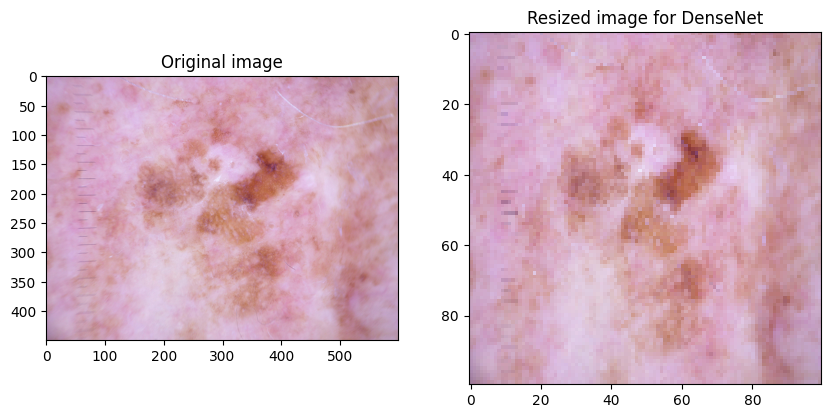

In [6]:
 # read the first image
fname_images = np.array(df_skin['image_id'])
file_to_read ='/content/HAM10000 PT1/'+str(fname_images[0])+'.jpg'

import cv2
from cv2 import imread, resize

img = imread(file_to_read)
img2 = resize(img,(100,100))

# show one exampe image

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img[:,:,::-1])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(img2[:,:,::-1])
plt.title('Resized image for DenseNet')
plt.show()

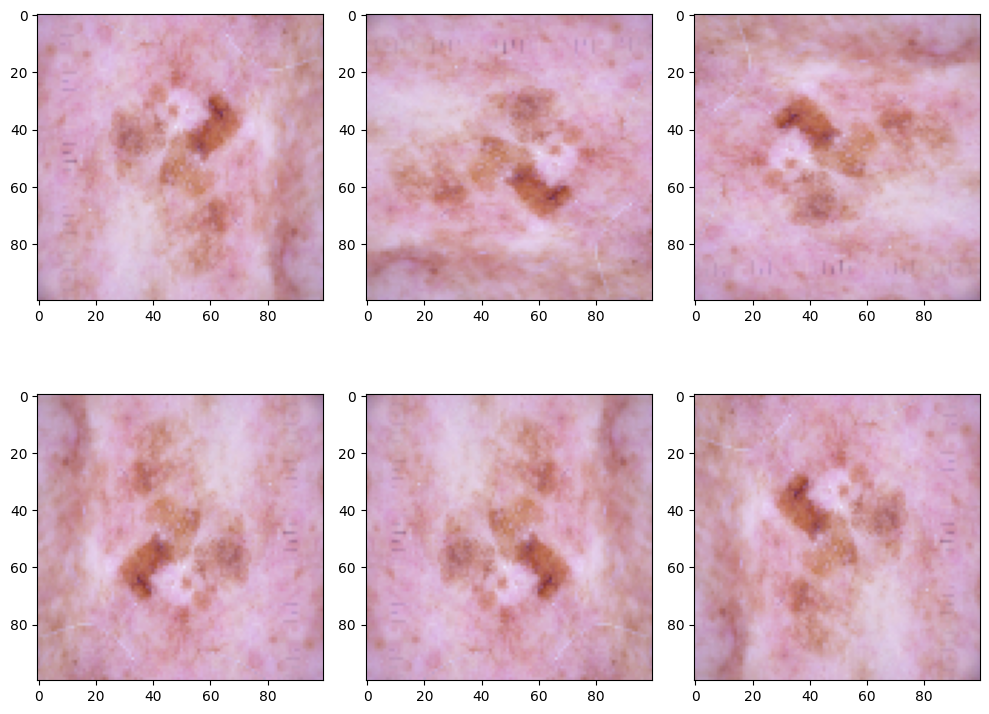

In [7]:

def produce_new_img(img2):
    # produce new images by rotating of flipping the original one
    # this helps to increase the dimension of the dataset, avoiding overfitting of a single class
    imga = cv2.rotate(img2,cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2,cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2,cv2.ROTATE_180)
    imgd = cv2.flip(img2,0)
    imge = cv2.flip(img2,1)
    return imga,imgb,imgc,imgd,imge

new_img = produce_new_img(img2)

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.imshow(img2[:,:,::-1])
for i in range(5):
    plt.subplot(2,3,2+i)
    plt.imshow(new_img[i][:,:,::-1])
plt.tight_layout()
plt.show()

In [8]:
# import images from 2 different folders

X = []
y = []

lista1 = os.listdir('/content/HAM10000 PT1/')
lista2 = os.listdir('/content/HAM10000 PT2/')


#import images from folder 1
for i in range(len(lista1)):
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg','')

  #features
    file_to_read ='/content/HAM10000 PT1/'+str(fname_image)
    img = imread(file_to_read)
    img2 = resize(img,(100,100))
    X.append(img2)

    #targets
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])

    # add more images for class between 1-6, rotating them
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            X.append(new_img[i])
            y.append(output[0])

    if i % int(100) == 0:
        print(i,'images loaded')

# import images from folder 2
for i in range(len(lista2)):
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg','')

    #features
    file_to_read ='/content/HAM10000 PT2/'+str(fname_image)
    img = imread(file_to_read)
    img2 = resize(img,(100,100))
    X.append(img2)

    #targets
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])

    # add more images for class between 1-6
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            X.append(new_img[i])
            y.append(output[0])

    if i % int(100) == 0:

        print(len(lista1)+i,'images loaded')

0 images loaded
100 images loaded
200 images loaded
300 images loaded
800 images loaded
1000 images loaded
1100 images loaded
1200 images loaded
1300 images loaded
1500 images loaded
1700 images loaded
1900 images loaded
2300 images loaded
2400 images loaded
2500 images loaded
2600 images loaded
2700 images loaded
2800 images loaded
2900 images loaded
3100 images loaded
3200 images loaded
3300 images loaded
3500 images loaded
3600 images loaded
3900 images loaded
4000 images loaded
4100 images loaded
4200 images loaded
4300 images loaded
4400 images loaded
4600 images loaded
4700 images loaded
4800 images loaded
4900 images loaded
5000 images loaded
5400 images loaded
5600 images loaded
5800 images loaded
6000 images loaded
6300 images loaded
6400 images loaded
6700 images loaded
7300 images loaded
7600 images loaded
7900 images loaded
8300 images loaded
8500 images loaded
8700 images loaded
8900 images loaded
9000 images loaded
9100 images loaded
9200 images loaded
9300 images loaded


In [9]:
df_skin.describe()

,age,lesion_ID
count,9958.000000,10015.000000
mean,51.863828,0.754968
std,16.968614,1.316223
min,0.000000,0.000000
25%,40.000000,0.000000
50%,50.000000,0.000000
75%,65.000000,1.000000
max,85.000000,6.000000


In [10]:
df_skin.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,lesion_type,lesion_ID
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,Benign keratosis-like lesions,2


In [11]:
# Checking for unique entries in each column
unique_counts = df_skin.nunique()

print("\nUnique entries in each column:")
print(unique_counts)


Unique entries in each column:
lesion_id        7470
image_id        10015
dx                  7
dx_type             4
age                18
sex                 3
localization       15
dataset             4
lesion_type         7
lesion_ID           7
dtype: int64


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
lesion_type      0
lesion_ID        0
dtype: int64


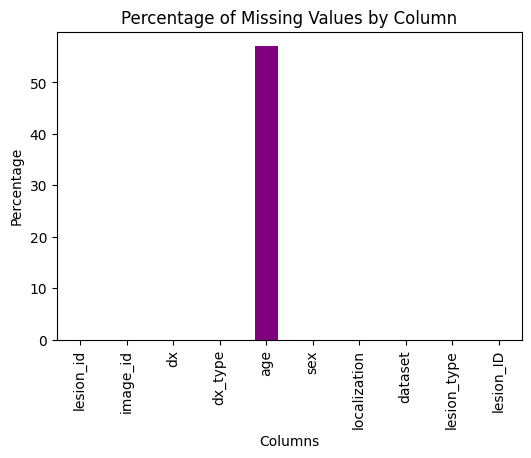

In [12]:
#Bar Plot of Missing Values
missing_values = df_skin.isnull().sum()
print(missing_values)
missing_values_percentage = (missing_values)
plt.figure(figsize=(6, 4))
missing_values_percentage.plot(kind='bar', color='purple')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('Percentage')
plt.xlabel('Columns')
plt.show()

In [13]:
# Define categorical and numerical columns
categorical_columns = ['lesion_id', 'image_id', 'dx', 'dx_type', 'sex', 'localization']
numerical_columns = ['age']

In [14]:
# Distribution of value count for Location of disease
for column in categorical_columns:
   df_skin['localization'].value_counts()

df_skin['localization'].value_counts()

localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64

<ipython-input-15-4568cdcb4fef>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_skin, x='localization', palette='Set1')


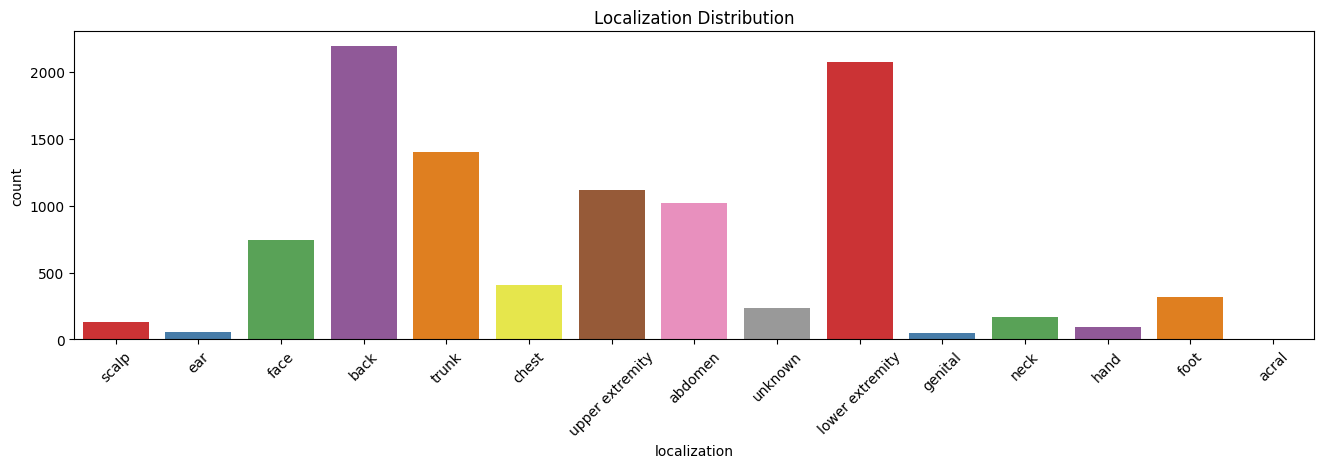

In [15]:
plt.figure(figsize=(16, 4))
sns.countplot(data=df_skin, x='localization', palette='Set1')
plt.title('Localization Distribution')
plt.xticks(rotation=45)
plt.show()

In [16]:
# Distribution of value count for Sex in the dataset
for column in categorical_columns:
    df_skin['sex'].value_counts()

df_skin['sex'].value_counts()

sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

<ipython-input-17-af1b8b3d93a7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_skin, x='sex', palette=['green', 'orange', 'red'])


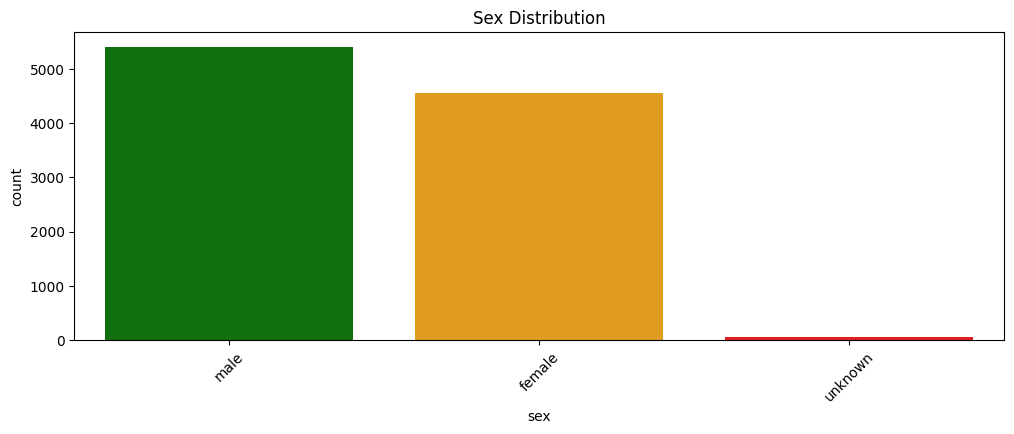

In [17]:
# Set the figure size
plt.figure(figsize=(12, 4))

# Create a count plot with custom colors (blue, orange, green)
sns.countplot(data=df_skin, x='sex', palette=['green', 'orange', 'red'])

# Add title and rotate x-axis labels
plt.title('Sex Distribution')
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [18]:
# Distribution of value count for Type of disease
for column in categorical_columns:
    df_skin['dx'].value_counts()

df_skin['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

<ipython-input-19-372c07fefbb7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_skin, x='dx', palette='Set1')


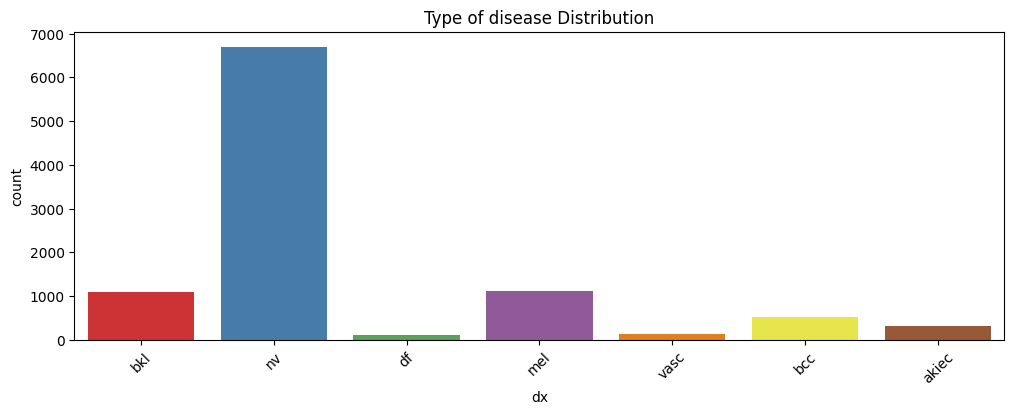

In [19]:
plt.figure(figsize=(12, 4))
sns.countplot(data=df_skin, x='dx', palette='Set1')
plt.title('Type of disease Distribution')
plt.xticks(rotation=45)
plt.show()

<ipython-input-20-b16dfe40a26c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_skin, x='age', palette='Set1')


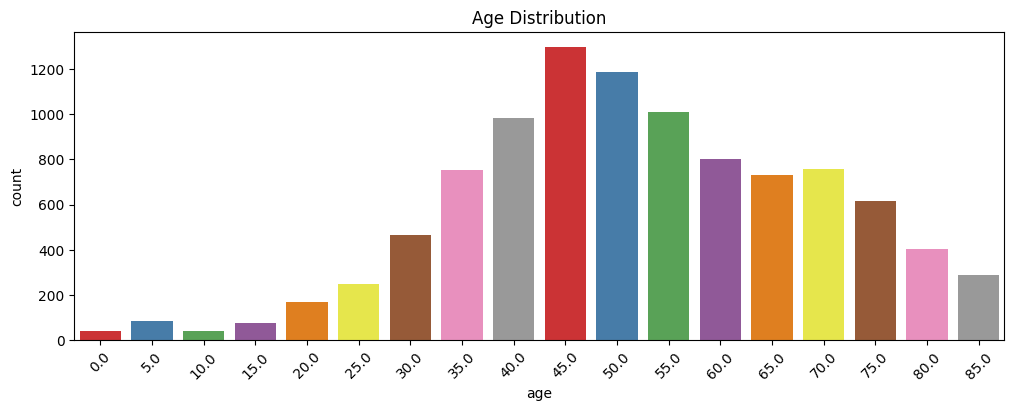

In [20]:
# Distribution of Age in pictorial format
plt.figure(figsize=(12, 4))
sns.countplot(data=df_skin, x='age', palette='Set1')
plt.title('Age Distribution')
plt.xticks(rotation=45)
plt.show()

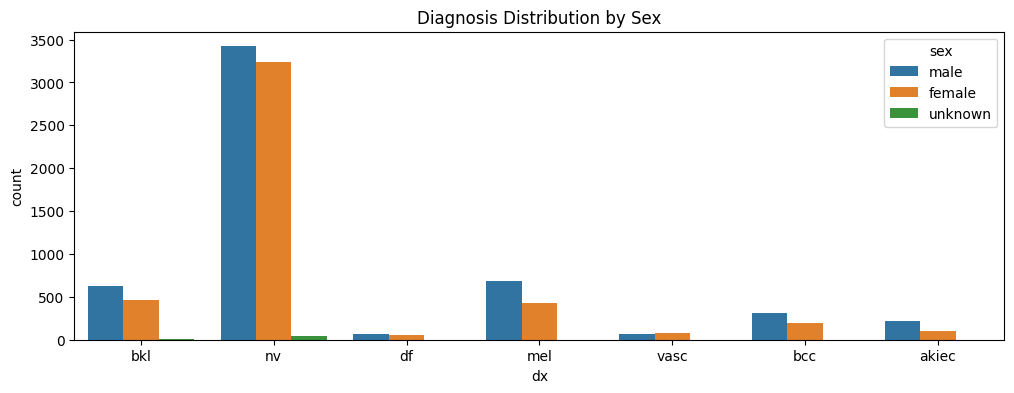

In [21]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=df_skin, x='dx', hue='sex')
plt.title('Diagnosis Distribution by Sex')
plt.show()

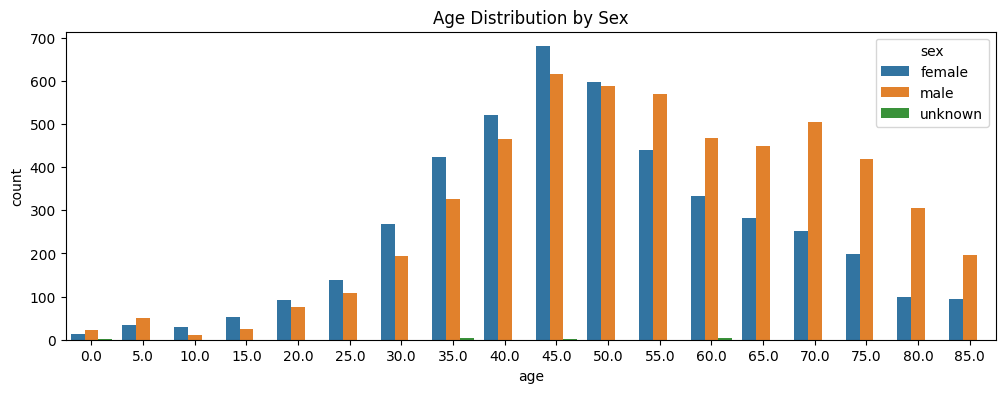

In [22]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=df_skin, x='age', hue='sex')
plt.title('Age Distribution by Sex')
plt.show()

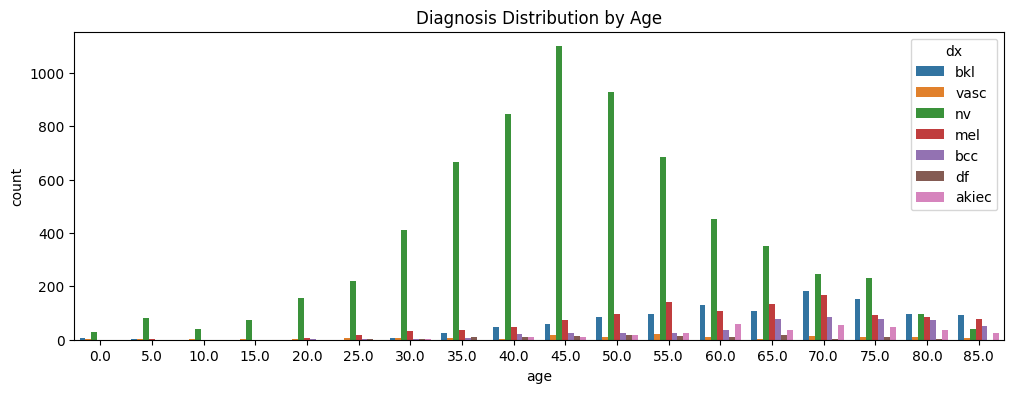

In [23]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=df_skin, x='age', hue='dx')
plt.title('Diagnosis Distribution by Age')
plt.show()

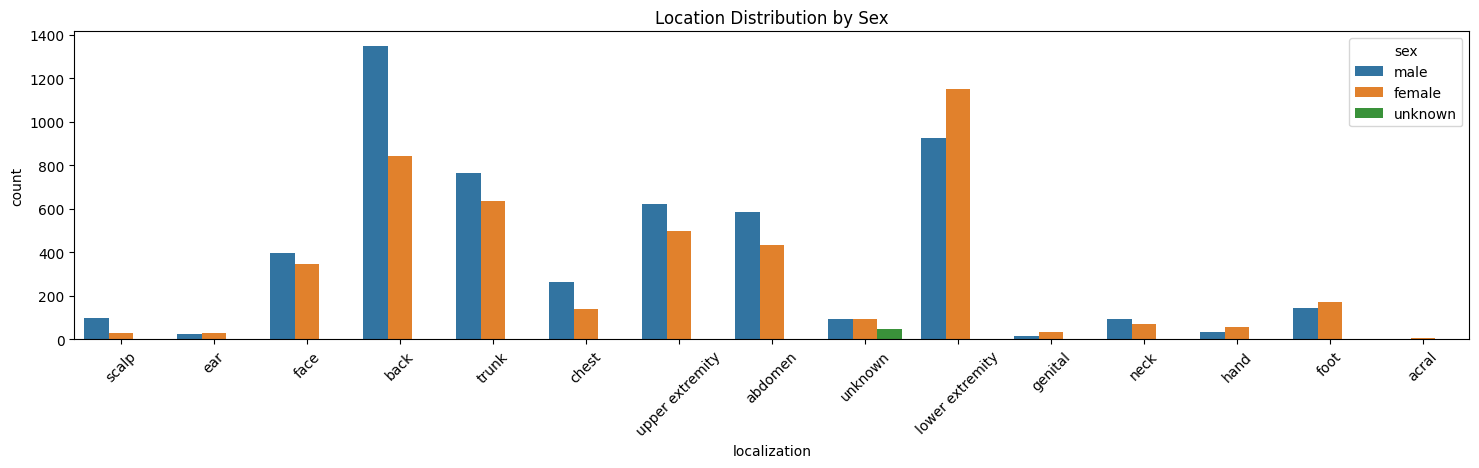

In [24]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(18, 4))
sns.countplot(data=df_skin, x='localization', hue='sex')
plt.title('Location Distribution by Sex')
plt.xticks(rotation=45)
plt.show()

In [25]:

from tensorflow.keras.utils import to_categorical

X = np.array(X)
y = np.array(y)

y_train = to_categorical(y, num_classes=7)

# #convert targets in dummy variables, as required by softmax activation function
# y_dumm = np.array(pd.get_dummies(y))

In [26]:
from sklearn.model_selection import train_test_split

# split in 70% training and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.30, random_state=50,stratify=y)

#
print('Train dataset shape',X_train.shape)
print('Test dataset shape',X_test.shape)

Train dataset shape (18595, 100, 100, 3)
Test dataset shape (7970, 100, 100, 3)


In [27]:
import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout, Activation, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense

In [28]:
from sklearn.utils.class_weight import compute_class_weight
y_id = np.array(df_skin['lesion_ID'])

# compute weights for the loss function, because the problem is unbalanced
class_weights = np.around(compute_class_weight(class_weight='balanced',classes=np.unique(y_id),y=y),2)
class_weights = dict(zip(np.unique(y_id),class_weights))

print('The problem is unbalanced. We need to provide class_weights ')
print(class_weights)

The problem is unbalanced. We need to provide class_weights 
{0: 0.57, 1: 0.57, 2: 0.58, 3: 1.23, 4: 1.93, 5: 4.45, 6: 5.5}


In [29]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam


def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(100, 100, 3))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

In [30]:
#Hyperparameters
dense_block_size = 6
layers_in_block = 8

growth_rate = 36
classes = 7
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 100, 24)         648       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 100, 100, 24)         0         ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 50, 50, 24)           0         ['activation[0][0]']          
 D)                                                                                           

In [31]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check if a GPU is recognized
physical_devices = tf.config.list_physical_devices('GPU')
print("GPUs Available: ", physical_devices)

batch_size = 32
epochs = 40

# Optimizer
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping_monitor = EarlyStopping(patience=100, monitor='val_accuracy', restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint(filepath='model.h5', save_weights_only=False, monitor='val_accuracy', mode='auto', save_best_only=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-6)


# Data Augmentation
datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2
)


datagen.fit(X_train)


# Create augmented training dataset
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)

# Validation dataset (no augmentation)
validation_datagen = ImageDataGenerator()
validation_gen = validation_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

# Train the model
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=validation_gen,
    callbacks=[early_stopping_monitor, model_checkpoint_callback, lr_scheduler],
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_test) // batch_size
)



GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/40
581/581 [==============================] - ETA: 0s - loss: 1.2432 - accuracy: 0.5295
Epoch 1: val_accuracy improved from -inf to 0.49674, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


581/581 [==============================] - 294s 431ms/step - loss: 1.2432 - accuracy: 0.5295 - val_loss: 1.3817 - val_accuracy: 0.4967 - lr: 1.0000e-04
Epoch 2/40
581/581 [==============================] - ETA: 0s - loss: 1.0675 - accuracy: 0.5880
Epoch 2: val_accuracy did not improve from 0.49674
581/581 [==============================] - 244s 420ms/step - loss: 1.0675 - accuracy: 0.5880 - val_loss: 1.3152 - val_accuracy: 0.4962 - lr: 1.0000e-04
Epoch 3/40
581/581 [==============================] - ETA: 0s - loss: 0.9808 - accuracy: 0.6191
Epoch 3: val_accuracy improved from 0.49674 to 0.57179, saving model to model.h5
581/581 [==============================] - 245s 422ms/step - loss: 0.9808 - accuracy: 0.6191 - val_loss: 1.1366 - val_accuracy: 0.5718 - lr: 1.0000e-04
Epoch 4/40
581/581 [==============================] - ETA: 0s - loss: 0.9330 - accuracy: 0.6345
Epoch 4: val_accuracy did not improve from 0.57179
581/581 [==============================] - 244s 420ms/step - loss: 0.9330

In [32]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

250/250 [==============================] - 25s 94ms/step - loss: 0.8918 - accuracy: 0.7517
Accuracy: 75.17%


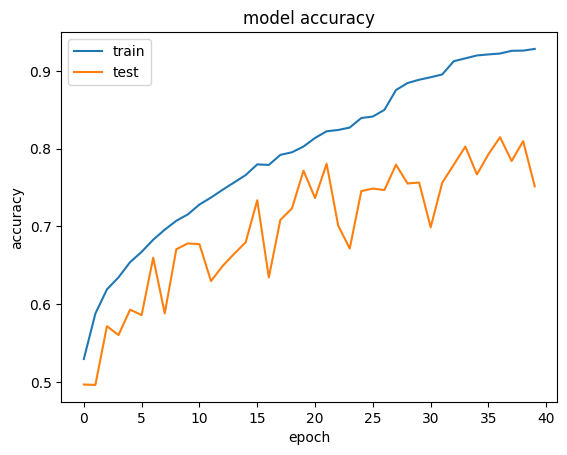

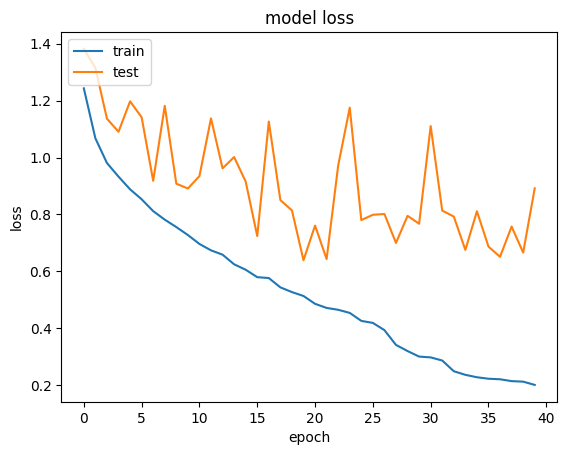

In [33]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
y_pred = model.predict(X_test)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)

    total += 1

print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)

print('Accuracy:', round(accurate/total*100, 3), '%')

250/250 [==============================] - 22s 85ms/step
Total-test-data; 7970 	accurately-predicted-data: 5991 	 wrongly-predicted-data:  1979
Accuracy: 75.169 %


In [35]:
best_model = load_model('model.h5')

# compute predictions
y_pred_prob = np.around(best_model.predict(X_test),3)
y_pred = np.argmax(y_pred_prob,axis=1)

y_test2 = np.argmax(y_test,axis=1)

250/250 [==============================] - 21s 83ms/step


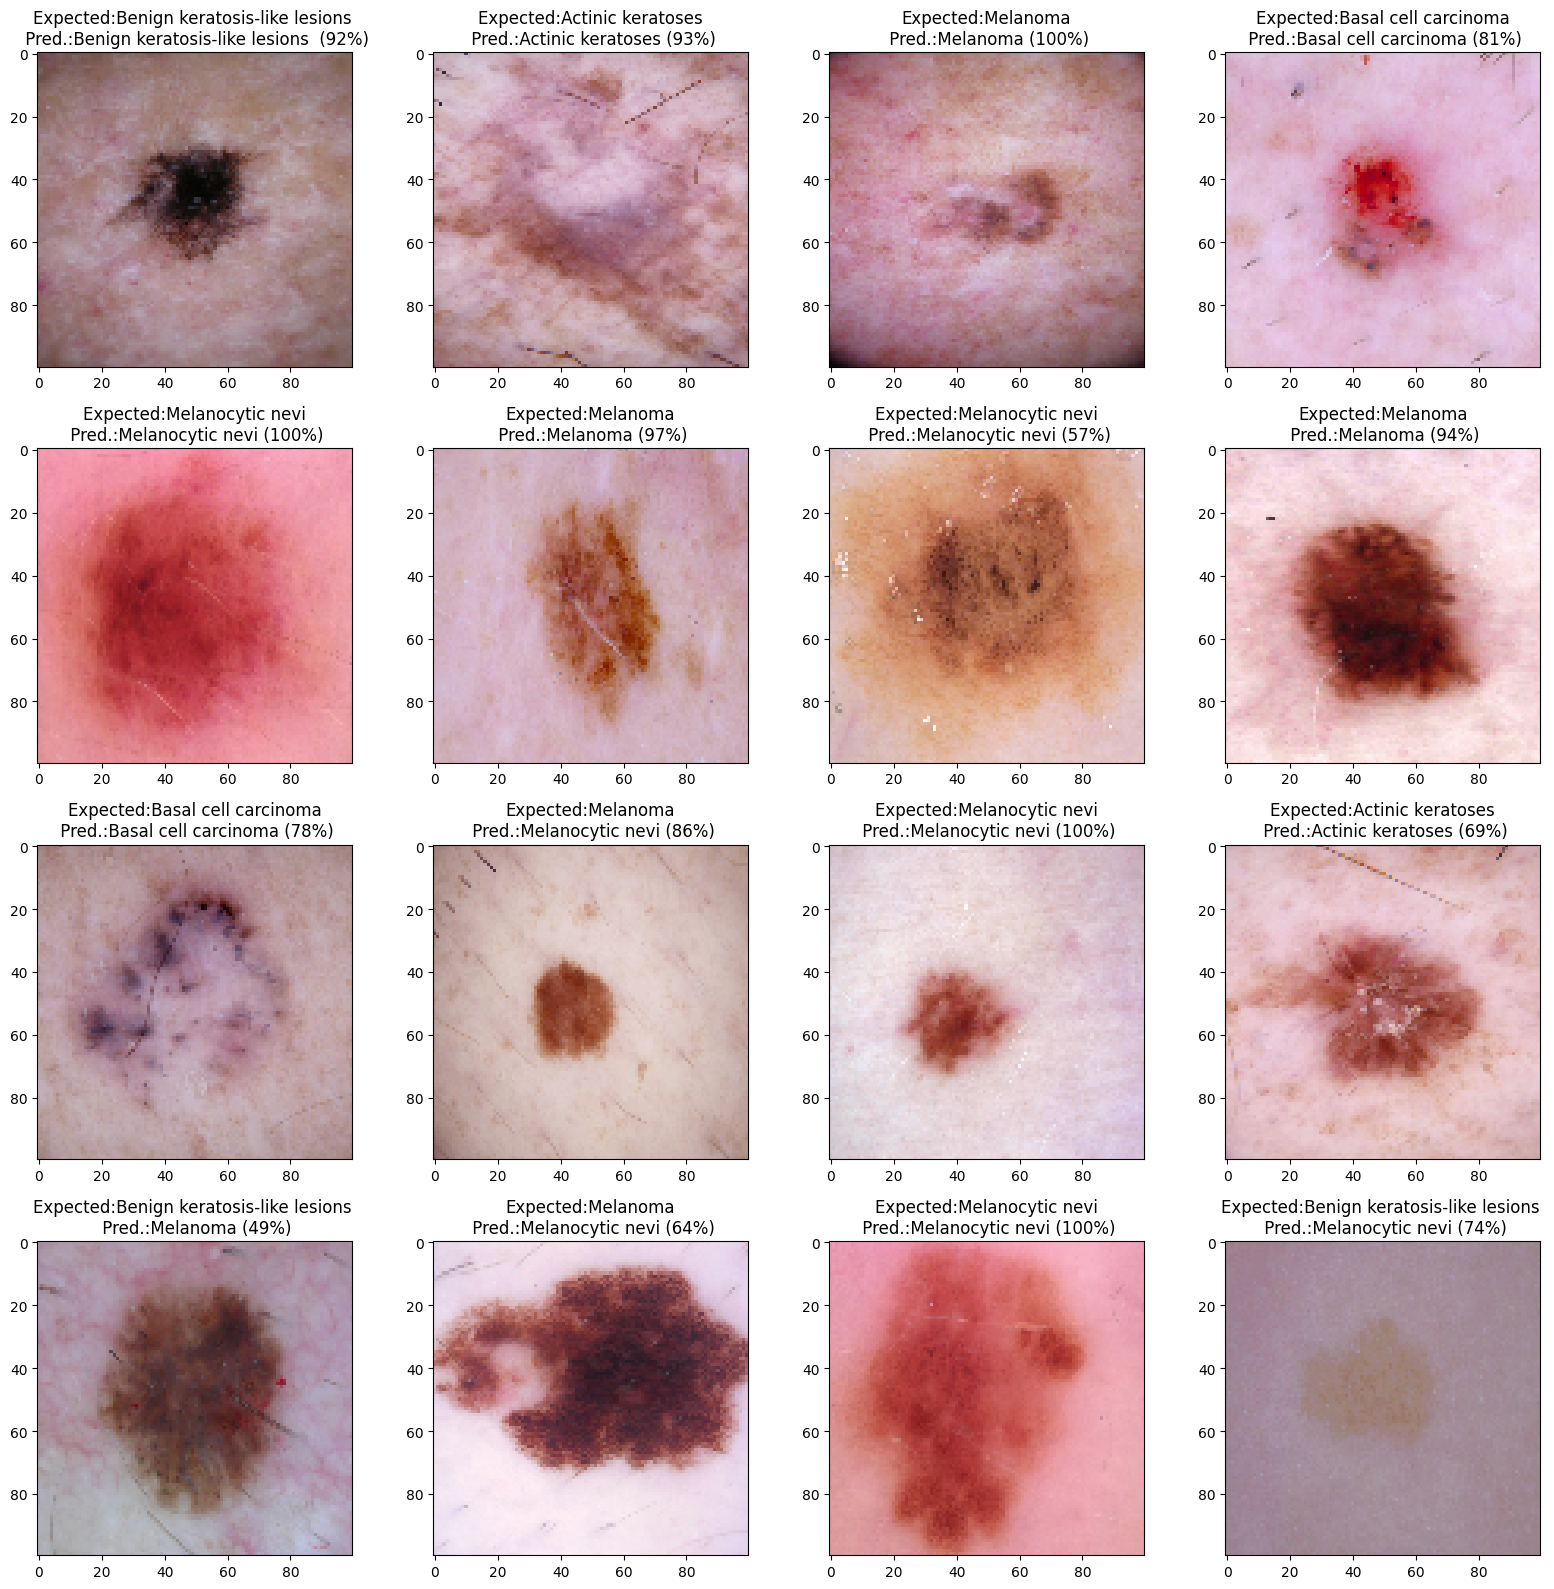

In [36]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = i+100
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2[index]]  #expected label
    label_pred = lesion_names[y_pred[index]]  #predicted label
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_figure.png',dpi=300)
plt.show()

In [43]:
print('Accuracy for label equal to 0')
print(np.mean(y_test2[y_test2 == 0] == y_pred[y_test2 == 0]))

print('Accuracy for label different from 0')
print(np.mean(y_test2[y_test2 != 0] == y_pred[y_test2 != 0]))

Accuracy for label equal to 0
0.9259443339960238
Accuracy for label different from 0
0.6928499496475328


In [44]:
acc_tot= []

for i in range(7):
    acc_parz = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]),2)
    lab_parz = lesion_names[i]
    print('accuracy for',lab_parz,'=',acc_parz)
    acc_tot.append(acc_parz)

accuracy for Melanocytic nevi = 0.93
accuracy for Melanoma = 0.73
accuracy for Benign keratosis-like lesions  = 0.73
accuracy for Basal cell carcinoma = 0.58
accuracy for Actinic keratoses = 0.48
accuracy for Vascular lesions = 0.89
accuracy for Dermatofibroma = 0.92


In [45]:
acc_tot = np.array(acc_tot)
freq = np.unique(y_test2,return_counts=True)[1]

np.sum(acc_tot*freq)/np.sum(freq)

0.7546787954830616

250/250 [==============================] - 20s 82ms/step


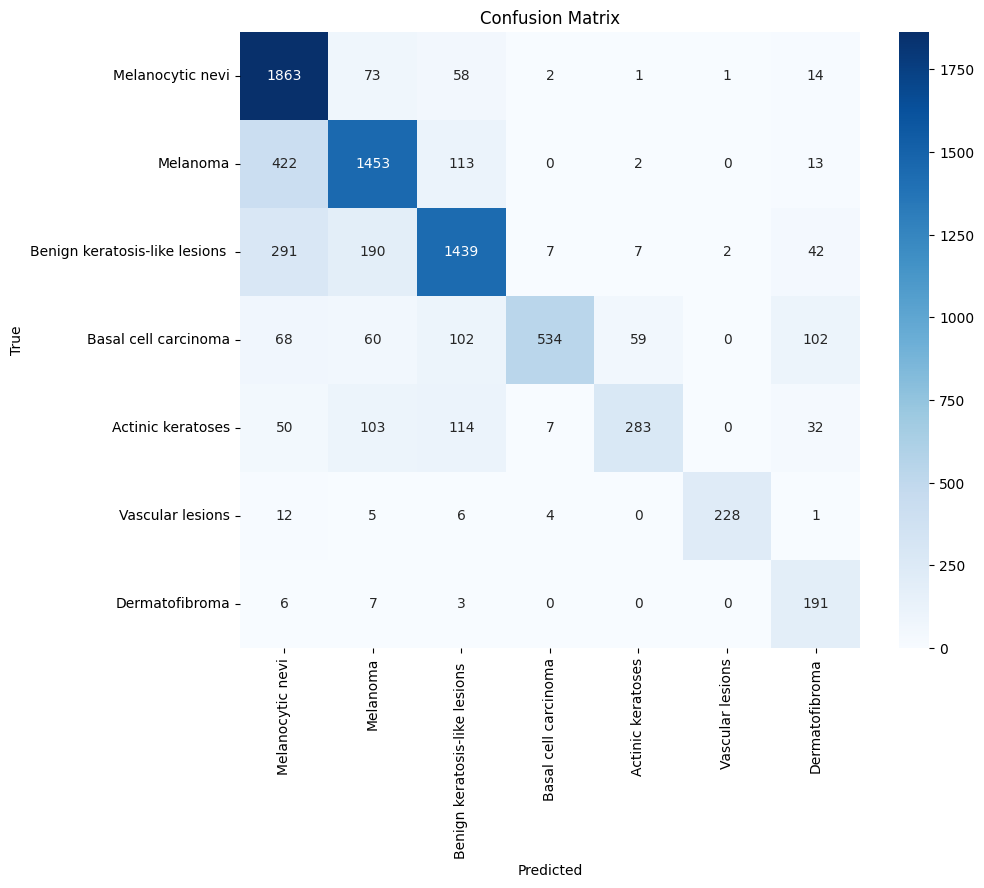

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Predict using the model
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)


# Compute confusion matrix
cm = confusion_matrix(y_test_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lesion_names, yticklabels=lesion_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Classification Report: {'Melanocytic nevi': {'precision': 0.6869469026548672, 'recall': 0.9259443339960238, 'f1-score': 0.7887383573243013, 'support': 2012}, 'Melanoma': {'precision': 0.7683765203595981, 'recall': 0.7254118821767349, 'f1-score': 0.746276322547509, 'support': 2003}, 'Benign keratosis-like lesions ': {'precision': 0.7841961852861036, 'recall': 0.7275025278058646, 'f1-score': 0.7547862575399948, 'support': 1978}, 'Basal cell carcinoma': {'precision': 0.9638989169675091, 'recall': 0.5772972972972973, 'f1-score': 0.7221095334685599, 'support': 925}, 'Actinic keratoses': {'precision': 0.8039772727272727, 'recall': 0.48047538200339557, 'f1-score': 0.6014877789585548, 'support': 589}, 'Vascular lesions': {'precision': 0.987012987012987, 'recall': 0.890625, 'f1-score': 0.9363449691991788, 'support': 256}, 'Dermatofibroma': {'precision': 0.4835443037974684, 'recall': 0.9227053140096618, 'f1-score': 0.6345514950166113, 'support': 207}, 'accuracy': 0.751693851944793, 'macro avg': 

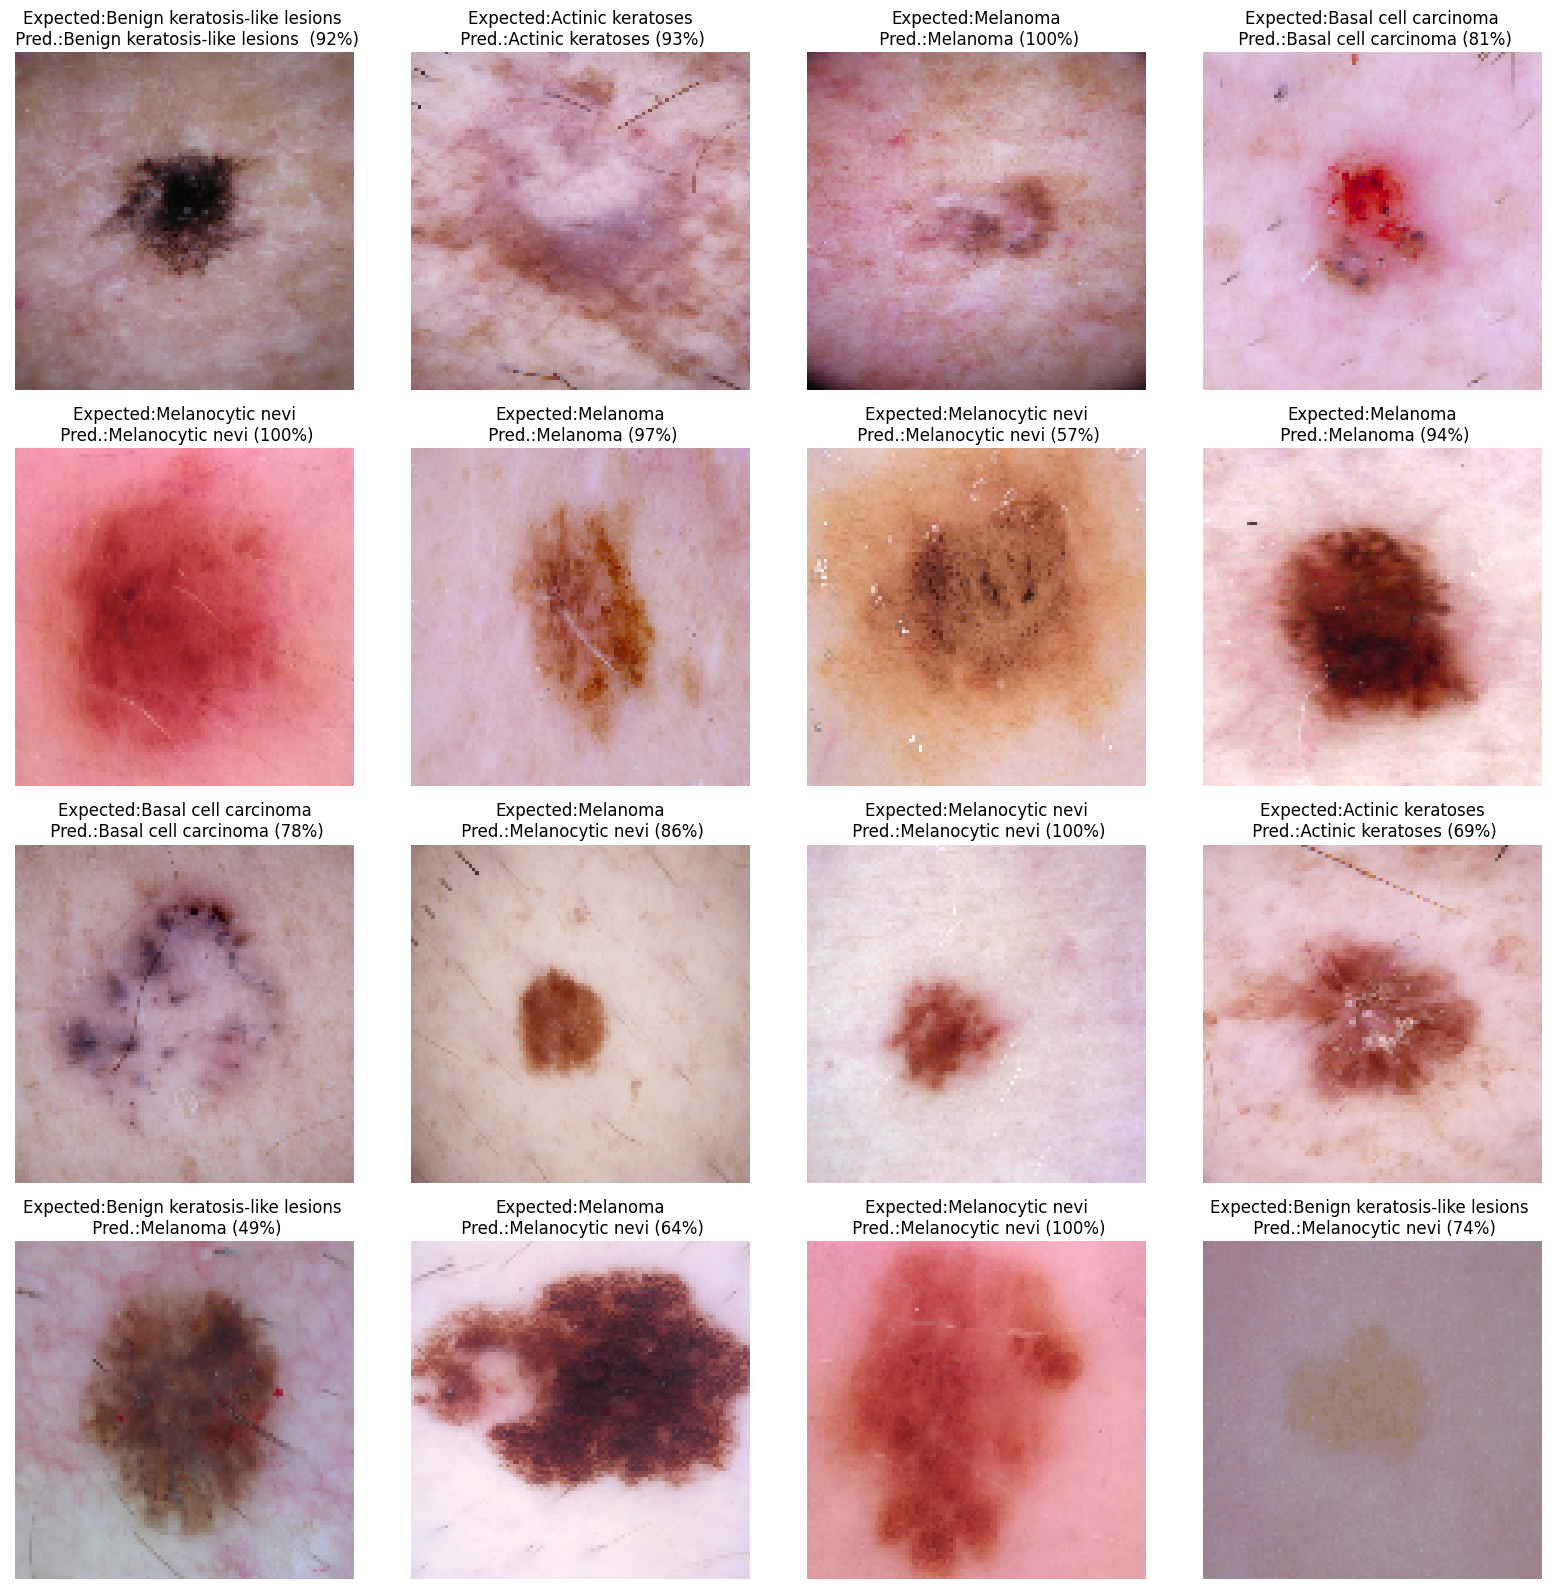

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns


# Classification report
report = classification_report(y_test_true, y_pred, target_names=lesion_names, output_dict=True)
print('Classification Report:', report)

# Extract metrics
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
specificity = (cm.sum() - cm.sum(axis=0) - cm.sum(axis=1) + np.diag(cm)).sum() / (cm.sum() - cm.sum(axis=1)).sum()
efficiency = (precision + recall) / 2

print(f'Precision: {precision:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Efficiency: {efficiency:.4f}')
print(f'F1 Score: {f1:.4f}')

# Compute predictions with the best model
y_pred_prob_best = np.around(best_model.predict(X_test), 3)
y_pred_best = np.argmax(y_pred_prob_best, axis=1)

# Display sample predictions
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    index = i + 100
    plt.imshow(X_test[index, :, :, ::-1])
    label_exp = lesion_names[y_test_true[index]]  # expected label
    label_pred = lesion_names[y_pred_best[index]]  # predicted label
    label_pred_prob = round(np.max(y_pred_prob_best[index]) * 100)
    plt.title('Expected:' + str(label_exp) + '\n Pred.:' + str(label_pred) + ' (' + str(label_pred_prob) + '%)')
    plt.axis('off')
plt.tight_layout()
plt.savefig('final_figure.png', dpi=300)
plt.show()